In [2]:
import pandas as pd
import json
from tqdm import tqdm
import statistics 
import pyspark.sql.functions as F
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from cmfrec import CMF

# Read rating

In [3]:
line_count = len(open("review.json", encoding='UTF-8').readlines())
user_ids, business_ids, stars, dates = [], [], [], []
with open("review.json", encoding='UTF-8') as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
ratings = pd.DataFrame(
    {"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates})
user_counts = ratings["user_id"].value_counts()

100%|██████████| 6685900/6685900 [01:03<00:00, 104538.74it/s]


In [4]:
useful_users = user_counts.loc[user_counts >= 5].index.tolist()
ratings = ratings[ratings.user_id.isin(useful_users)].sort_values(by=['user_id', 'date'])

In [34]:
ratings.head()

user_id             business_id  rating  \
5178360  ---1lKK3aKOuomHnwAkAow  5cbsjFtrntUAeUx51FaFTg     4.0   
5934075  ---1lKK3aKOuomHnwAkAow  --9e1ONYQuAa-CB_Rrw7Tw     4.0   
4312893  ---1lKK3aKOuomHnwAkAow  ifEHr-ZnGFSKgJVsywiAFg     5.0   
2915094  ---1lKK3aKOuomHnwAkAow  kosTPb88O4Q0XGbVbEOGCA     4.0   
809678   ---1lKK3aKOuomHnwAkAow  rq5dgoksPHkJwJNQKlGQ7w     5.0   

                        date  
5178360  2008-11-11 04:31:46  
5934075  2008-11-11 04:40:05  
4312893  2009-01-16 21:49:36  
2915094  2010-10-16 23:27:02  
809678   2010-10-16 23:31:28

# Read User Info

In [5]:
line_count = len(open("user.json", encoding = 'UTF-8').readlines())
user_ids, yelping_sinces = [], []
# usefuls, funnys, cools = [], [], []
fanss, elites = [], []
compliment_hots, compliment_mores, compliment_profiles, compliment_cutes = [], [], [], []
compliment_lists, compliment_notes, compliment_plains, compliment_cools = [], [], [], []
compliment_funnys, compliment_writers, compliment_photos = [], [], []
with open("user.json", encoding = 'UTF-8') as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        #review_counts += [blob["review_count"]]
        yelping_sinces += [blob["yelping_since"]]
        fanss += [blob["fans"]] 
        elites += [blob["elite"]]
        compliment_hots += [blob["compliment_hot"]]
        compliment_mores += [blob["compliment_more"]]
        compliment_profiles += [blob["compliment_profile"]]
        compliment_cutes += [blob["compliment_cute"]]
        compliment_lists += [blob["compliment_list"]]
        compliment_notes += [blob["compliment_note"]]
        compliment_plains += [blob["compliment_plain"]]
        compliment_cools += [blob["compliment_cool"]]
        compliment_funnys += [blob["compliment_funny"]]
        compliment_writers += [blob["compliment_writer"]]
        compliment_photos += [blob["compliment_photos"]]

users = pd.DataFrame(
{"user_id": user_ids, "yelping_since": yelping_sinces, "fans": fanss, "elite": elites, 
"compliment_hot": compliment_hots, "compliment_more":compliment_mores, "compliment_profile": compliment_profiles,
"compliment_cute":compliment_cutes, "compliment_list":compliment_lists,
"compliment_note": compliment_notes, "compliment_plain": compliment_plains,
"compliment_cool": compliment_cools, "compliment_funny": compliment_funnys,
"compliment_writer": compliment_writers, "compliment_photos": compliment_photos}
)

100%|██████████| 1637138/1637138 [00:26<00:00, 61980.18it/s]


In [6]:
# replace blank value with nan
users['elite'] = users['elite'].replace(r'^\s*$', np.nan, regex=True).head()

# count number of nan in 'elite'
print("Number of NAs:", users['elite'].isna().sum())
print("Total number of observations:", len(users['elite']))

Number of NAs: 1637136
Total number of observations: 1637138


In [7]:
# Compute number of years that a user has been using Yelp
users['year'] = 2019 - pd.DatetimeIndex(users['yelping_since']).year

In [8]:
user_attr = users[['user_id', 'year']] 
user_attr.head()

user_id  year
0  l6BmjZMeQD3rDxWUbiAiow     6
1  4XChL029mKr5hydo79Ljxg     6
2  bc8C_eETBWL0olvFSJJd0w     6
3  dD0gZpBctWGdWo9WlGuhlA     5
4  MM4RJAeH6yuaN8oZDSt0RA     6

# Read Item Info

In [9]:
line_count_busi = len(open("business.json", encoding = 'UTF-8').readlines())

business_id, name, address, city, state, postal_code, latitude, longitude=[],[],[],[],[],[],[],[]
stars, review_count, is_open, attributes, categories, hours =[],[],[],[],[],[]


with open("business.json", encoding = 'UTF-8') as f:
    for line in tqdm(f, total=line_count_busi):
        blob = json.loads(line)
        business_id += [blob["business_id"]]
        #review_counts += [blob["review_count"]]
        name += [blob["name"]]
        address += [blob["address"]] 
        city += [blob["city"]]
        state += [blob["state"]]
        postal_code += [blob["postal_code"]]
        latitude += [blob["latitude"]]
        longitude += [blob["longitude"]]
        stars += [blob["stars"]]
        review_count += [blob["review_count"]]
        is_open += [blob["is_open"]]
        attributes += [blob["attributes"]]
        categories += [blob["categories"]]
        hours += [blob["hours"]]

items = pd.DataFrame(
{"business_id": business_id, "name": name, "address": address, "city": city, 
"state": state, "postal_code":postal_code, "latitude": latitude,
"longitude":longitude, "stars":stars,
"review_count": review_count, "is_open": is_open,
"attributes": attributes, "categories": categories,
"hours": hours}
)

100%|██████████| 192609/192609 [00:04<00:00, 45751.84it/s]


In [10]:
items['state_id']= items.state.astype('category').cat.codes

In [11]:
item_attr = items[['business_id','state', 'stars', 'review_count','state_id']]
item_attr.head(1)

business_id state  stars  review_count  state_id
0  1SWheh84yJXfytovILXOAQ    AZ    3.0             5         4

# Train and Test

In [12]:
ratings.head(1)

user_id             business_id  rating  \
5178360  ---1lKK3aKOuomHnwAkAow  5cbsjFtrntUAeUx51FaFTg     4.0   

                        date  
5178360  2008-11-11 04:31:46

# Transform UserId and ItemId

In [13]:
# merge ratings, user attributes and item attributes
ranting_and_user_attr = ratings.merge(user_attr, on = 'user_id', how = 'left')
ranting_and_user_item = ranting_and_user_attr.merge(item_attr, on = 'business_id', how = 'left')
ranting_and_user_item['ItemId'] = ranting_and_user_item.business_id.astype('category').cat.codes
ranting_and_user_item['UserId'] = ranting_and_user_item.user_id.astype('category').cat.codes

In [14]:
ranting_and_user_item = ranting_and_user_item.rename(columns={"rating": "Rating"})

In [15]:
# select relevant features
rating_num = ranting_and_user_item[['user_id','business_id','Rating','date','ItemId','UserId']]
user_attr_num = ranting_and_user_item[['user_id','year','UserId']]
item_attr_num = ranting_and_user_item[['business_id','state_id', 'stars', 'review_count', 'ItemId']]

In [68]:
rating_num.Rating.count()

4538272

In [15]:
rating_num.head(1)

user_id             business_id  Rating  \
0  ---1lKK3aKOuomHnwAkAow  5cbsjFtrntUAeUx51FaFTg     4.0   

                  date  ItemId  UserId  
0  2008-11-11 04:31:46   19063       0

In [16]:
user_attr_num.head(1)

user_id  year  UserId
0  ---1lKK3aKOuomHnwAkAow    12       0

In [17]:
item_attr_num.head(1)

business_id  state_id  stars  review_count  ItemId
0  5cbsjFtrntUAeUx51FaFTg        19    3.0           154   19063

In [69]:
# train and test split
test = rating_num.groupby('user_id').tail(1)
train = rating_num.drop(test.index)

In [98]:
test.user_id.count()

286130

In [99]:
train.user_id.count()

4252142

In [70]:
train = train[['UserId','ItemId','Rating']]
train.head(1)

UserId  ItemId  Rating
0       0   19063     4.0

In [71]:
test = test[['UserId','ItemId','Rating']]
test.head(1)

UserId  ItemId  Rating
127       0   54831     5.0

In [72]:
user_attr = user_attr_num[['UserId','year']]
item_attr = item_attr_num[['ItemId','state_id']]

In [73]:
# drop duplicate rows
user_attr2 = user_attr_num[['UserId','year']].drop_duplicates()
item_attr2 = item_attr_num[['ItemId','state_id']].drop_duplicates()

In [42]:
item_attr2.head()

ItemId  state_id
0   19063        19
1       5        19
2  135553        19
3  141792        19
4  162126        19

## Hyper-parameter tuning

In [74]:
def cmf_rec(train, test, user_info, item_info, wm, wu, wi):
    """Fit CMF using the input parameters 
    and return rmse
    """
    recommender = CMF(reg_param=1e-4, random_seed=1, w_main=wm, w_user=wu, w_item=wi)
    recommender.fit(ratings=train, user_info=user_info, item_info=item_info)
    test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
    rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    return rmse

In [75]:
# Sample 1% of training data for parameter tuning
rating_CV_1 = train
index = np.arange(0, len(rating_CV_1))
rating_CV_1 = rating_CV_1.sample(frac = 0.01, random_state=1)

index = np.arange(0, len(rating_CV_1))

rating_CV_1['index'] = index
rating_CV_1 = rating_CV_1.set_index('index')


In [101]:
print("number of users:", len(rating_CV_1.UserId.unique()))

number of users: 33664


In [102]:
print("number of items:", len(rating_CV_1.ItemId.unique()))

number of items: 25835


In [181]:
# parameters to fit
w_main = [1,1,1.5,0.5,1, 1.5, 0.5, 1, 2, 0.5,0.5]
w_user = [0,1,0.5,1.5,0,0,0,1,0.5,2,0.5]
w_item = [0,0,0,0,1,0.5,1.5,1,0.5,0.5,2]

In [182]:
params = pd.DataFrame({"w_main": w_main, "w_user": w_user, "w_item": w_item})

In [22]:
from sklearn.model_selection import train_test_split

In [50]:
i = 0
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.008365
  Number of iterations: 304
  Number of functions evaluations: 346
w_main: 1.0 w_user: 0.0 w_item: 0.0 RMSE= 1.3321682688044891


In [51]:
i = 1
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.371589
  Number of iterations: 400
  Number of functions evaluations: 442
w_main: 1.0 w_user: 1.0 w_item: 0.0 RMSE= 1.3312456553638319


In [52]:
i = 2
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.370918
  Number of iterations: 466
  Number of functions evaluations: 512
w_main: 1.5 w_user: 0.5 w_item: 0.0 RMSE= 1.332239290206964


In [48]:
i = 3
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.371788
  Number of iterations: 336
  Number of functions evaluations: 370
w_main: 0.5 w_user: 1.5 w_item: 0.0 RMSE= 1.3318301456500043


In [49]:
i = 4
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.752409
  Number of iterations: 329
  Number of functions evaluations: 369
w_main: 1.0 w_user: 0.0 w_item: 1.0 RMSE= 1.3323093651647977


In [53]:
i = 5
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.751958
  Number of iterations: 403
  Number of functions evaluations: 453
w_main: 1.5 w_user: 0.0 w_item: 0.5 RMSE= 1.3315805402417862


In [54]:
i = 6
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.752550
  Number of iterations: 351
  Number of functions evaluations: 386
w_main: 0.5 w_user: 0.0 w_item: 1.5 RMSE= 1.3321185466897616


In [55]:
i = 7
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.115669
  Number of iterations: 368
  Number of functions evaluations: 410
w_main: 1.0 w_user: 1.0 w_item: 1.0 RMSE= 1.3320414309546644


In [56]:
i = 8
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.114476
  Number of iterations: 451
  Number of functions evaluations: 521
w_main: 2.0 w_user: 0.5 w_item: 0.5 RMSE= 1.332152559156392


In [57]:
i = 9
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.115502
  Number of iterations: 249
  Number of functions evaluations: 270
w_main: 0.5 w_user: 2.0 w_item: 0.5 RMSE= 1.3323361487834013


In [58]:
i = 10
    
w_main = params.iloc[i][0]
w_user = params.iloc[i][1]
w_item = params.iloc[i][2]

train, test = train_test_split(rating_CV_1, test_size=0.33, random_state=42)
result = cmf_rec(train, test, user_attr2, item_attr2, 
                         float(w_main), float(w_user), float(w_item))
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", result)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1.115144
  Number of iterations: 354
  Number of functions evaluations: 393
w_main: 0.5 w_user: 0.5 w_item: 2.0 RMSE= 1.3323946604932142


In [183]:
# collect results
rmse = [1.3321682688044891, 
        1.3312456553638319, 1.332239290206964, 1.3318301456500043,
        1.3323093651647977, 1.3315805402417862, 1.3321185466897616,
        1.3320414309546644, 1.332152559156392, 1.3323361487834013,
        1.3323946604932142]

In [184]:
params['rmse'] = rmse
params

w_main  w_user  w_item      rmse
0      1.0     0.0     0.0  1.332168
1      1.0     1.0     0.0  1.331246
2      1.5     0.5     0.0  1.332239
3      0.5     1.5     0.0  1.331830
4      1.0     0.0     1.0  1.332309
5      1.5     0.0     0.5  1.331581
6      0.5     0.0     1.5  1.332119
7      1.0     1.0     1.0  1.332041
8      2.0     0.5     0.5  1.332153
9      0.5     2.0     0.5  1.332336
10     0.5     0.5     2.0  1.332395

In [185]:
# Sort by rmse
params.sort_values(by=['rmse'])

w_main  w_user  w_item      rmse
1      1.0     1.0     0.0  1.331246
5      1.5     0.0     0.5  1.331581
3      0.5     1.5     0.0  1.331830
7      1.0     1.0     1.0  1.332041
6      0.5     0.0     1.5  1.332119
8      2.0     0.5     0.5  1.332153
0      1.0     0.0     0.0  1.332168
2      1.5     0.5     0.0  1.332239
4      1.0     0.0     1.0  1.332309
9      0.5     2.0     0.5  1.332336
10     0.5     0.5     2.0  1.332395

In [186]:
import matplotlib.pyplot as plt
import plotly.express as px

In [187]:
fig = px.parallel_coordinates(params, color=params.index, labels={"index": "index", "w_main": "w_main",
                "w_user": "w_user", "w_item": "w_item",
                "rmse": "RMSE", },
                    color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

## Tune matrix weights

In [79]:
w_main = 1
w_user = 1
w_item = 0

best_recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item)
best_recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating_opt']=best_recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating_opt - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.059301
  Number of iterations: 112
  Number of functions evaluations: 123
w_main: 1 w_user: 1 w_item: 0 RMSE= 1.4583554284304834


In [76]:
w_main = 2
w_user = 2
w_item = 0

recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item)
recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3.635240
  Number of iterations: 184
  Number of functions evaluations: 218
w_main: 2 w_user: 2 w_item: 0 RMSE= 1.4315561942060693


In [78]:
w_main = 3
w_user = 3
w_item = 0

recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item,
                 maxiter=300)
recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5.146503
  Number of iterations: 275
  Number of functions evaluations: 324
w_main: 3 w_user: 3 w_item: 0 RMSE= 1.4135122992845035


In [82]:
w_main = 5
w_user = 5
w_item = 0

recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item,
                 maxiter=300)
recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 8.042334
  Number of iterations: 300
  Number of functions evaluations: 321
w_main: 5 w_user: 5 w_item: 0 RMSE= 1.389111075941639


In [85]:
w_main = 7
w_user = 7
w_item = 0

recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item,
                 maxiter=300)
recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 10.829509
  Number of iterations: 300
  Number of functions evaluations: 333
w_main: 7 w_user: 7 w_item: 0 RMSE= 1.3725767853329234


In [90]:
w_main = 9
w_user = 9
w_item = 0

recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item,
                 maxiter=300)
recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 15.353099
  Number of iterations: 300
  Number of functions evaluations: 335
w_main: 9 w_user: 9 w_item: 0 RMSE= 1.3677835549183464


In [80]:
def coverage(df, pred_rating, rating):
    users = sum(abs(np.array(df[pred_rating]) - np.array(df[rating])) < 1)
    total = len(np.array(df[pred_rating]))
    coverage = users / total
    return coverage

In [91]:
uc = coverage(test, 'pred_rating', 'Rating')
uc

0.4936462447139412

In [99]:
w_main = 11
w_user = 11
w_item = 0

recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item,
                 maxiter=300)
recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 20.507574
  Number of iterations: 300
  Number of functions evaluations: 332
w_main: 11 w_user: 11 w_item: 0 RMSE= 1.372803076330908


In [100]:
w_main = [1,2,3,5,7,9,11]
w_user = [1,2,3,5,7,9,11]
w_item = [0,0,0,0,0,0,0]
model = pd.DataFrame({"w_main": w_main, "w_user": w_user, "w_item": w_item})

In [101]:
# Collect results
rmse = [1.4583554284304834, 1.4315561942060693, 
       1.4135122992845035, 1.389111075941639, 1.3725767853329234,
       1.3677835549183464, 1.372803076330908]

In [102]:
model['rmse'] = rmse
model

w_main  w_user  w_item      rmse
0       1       1       0  1.458355
1       2       2       0  1.431556
2       3       3       0  1.413512
3       5       5       0  1.389111
4       7       7       0  1.372577
5       9       9       0  1.367784
6      11      11       0  1.372803

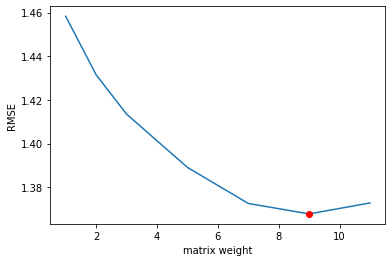

In [111]:
# Plot change in RMSE
import matplotlib.pyplot as plt
plt.plot(model['w_main'], model['rmse'])
plt.plot(9, 1.3677835549183464, 'ro')
plt.ylabel('RMSE')
plt.xlabel('matrix weight')
plt.show()

### Final Model

In [104]:
# Final Model
w_main = 9
w_user = 9
w_item = 0

recommender = CMF(k=10, reg_param=1e-4, random_seed=1, w_main=w_main, w_user= w_user, w_item=w_item,
                 maxiter=300)
recommender.fit(ratings=train, user_info=user_attr2, item_info=item_attr2)
test['pred_rating']=recommender.predict(test.UserId,test.ItemId)
rmse = ((test.pred_rating - test.Rating) ** 2).mean() ** .5
    
print("w_main:",w_main, "w_user:", w_user, "w_item:", w_item, "RMSE=", rmse)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 15.353099
  Number of iterations: 300
  Number of functions evaluations: 335
w_main: 9 w_user: 9 w_item: 0 RMSE= 1.3677835549183464


In [188]:
test.head()

UserId  ItemId  Rating  pred_rating  pred_rating_opt
127       0   54831     5.0     4.616414         4.298876
139       1   77193     2.0     3.929923         3.770798
204       2   62566     5.0     3.845833         3.749744
239       3   35725     3.0     3.805139         3.505103
254       4   91051     4.0     4.081263         3.798820

### Calculate catalog coverage

In [195]:
REC_ITEMS = []
for user in users:
    rec_items = list(recommender.topN(user=user, n=5))
    REC_ITEMS = REC_ITEMS + rec_items

In [196]:
REC_ITEMS = np.unique(np.array(REC_ITEMS))

In [197]:
# Catalog coverage
# number of recommended items / number of items in total
print("catalog coverage:", len(REC_ITEMS) / 185723)

catalog coverage: 0.0006192017143810944


### Calculate Precision

In [158]:
users = test['UserId']

In [168]:
# Precision at 5
precision = []
for user in users:
    rec_items = recommender.topN(user=user, n=5)
    true_item = int(test[test.UserId == user]['ItemId'])
    hit = len(set(rec_items).intersection(set([true_item]))) * 1.0 / 5
    precision.append(hit)
    

In [180]:
print("precision overall:", np.mean(precision))

precision overall: 0.00029427183448083044


In [170]:
prec = pd.DataFrame({'UserId': users, 'precision': precision})

In [175]:
prec['ItemId'] = test.ItemId

In [176]:
prec.head()

UserId  precision  ItemId
127       0        0.0   54831
139       1        0.0   77193
204       2        0.0   62566
239       3        0.0   35725
254       4        0.0   91051

In [172]:
inactive_prec = prec[prec.UserId.isin(not_active_users)]

average_prec = prec[prec.UserId.isin(average_users)]

vactive_prec = prec[prec.UserId.isin(very_active_users)]

In [173]:
print("precision - inactive users:", np.mean(inactive_prec['precision']))
print("precision - average users:", np.mean(average_prec['precision']))
print("precision - very active users:", np.mean(vactive_prec['precision']))

precision - inactive users: 0.0003233194126364017
precision - average users: 0.00032318376068375996
precision - very active users: 0.0001501752044051394


In [177]:
unpopular_prec = prec[prec.ItemId.isin(unpopular_items)]

moderate_prec = prec[prec.ItemId.isin(moderate_items)]

popular_prec = prec[prec.ItemId.isin(popular_items)]

In [178]:
print("precision - unpopular items:", np.mean(unpopular_prec['precision']))
print("precision - moderate items:", np.mean(moderate_prec['precision']))
print("precision - popular items:", np.mean(popular_prec['precision']))

precision - unpopular items: 0.0
precision - moderate items: 5.4422053490599084e-05
precision - popular items: 0.001268193769010027


### RMSE by users and by items

In [115]:
rating_num.head()

user_id             business_id  Rating  \
0  ---1lKK3aKOuomHnwAkAow  5cbsjFtrntUAeUx51FaFTg     4.0   
1  ---1lKK3aKOuomHnwAkAow  --9e1ONYQuAa-CB_Rrw7Tw     4.0   
2  ---1lKK3aKOuomHnwAkAow  ifEHr-ZnGFSKgJVsywiAFg     5.0   
3  ---1lKK3aKOuomHnwAkAow  kosTPb88O4Q0XGbVbEOGCA     4.0   
4  ---1lKK3aKOuomHnwAkAow  rq5dgoksPHkJwJNQKlGQ7w     5.0   

                  date  ItemId  UserId  
0  2008-11-11 04:31:46   19063       0  
1  2008-11-11 04:40:05       5       0  
2  2009-01-16 21:49:36  135553       0  
3  2010-10-16 23:27:02  141792       0  
4  2010-10-16 23:31:28  162126       0

In [116]:
user_counts = rating_num["UserId"].value_counts()
users = user_counts.index.tolist()
d = {'review_count' : user_counts}
activity = pd.DataFrame(d)
activity = activity.reset_index()
activity = activity.rename(columns={"index": "UserId"})

In [117]:
activity['label'] = pd.cut(activity['review_count'], bins=[5, 10, 20, float('Inf')], right = False,
                             labels=['not so active', 'average', 'very active'])

activity.head()

UserId  review_count        label
0   62563          4129  very active
1  176036          2354  very active
2  117735          1822  very active
3   68798          1764  very active
4   64263          1727  very active

In [118]:
activity['label'].value_counts()

not so active    163306
average           74880
very active       47944
Name: label, dtype: int64

In [125]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [127]:
very_active_users = activity.loc[activity.label == "very active"]['UserId'].tolist()
average_users = activity.loc[activity.label == "average"]['UserId'].tolist()
not_active_users = activity.loc[activity.label == "not so active"]['UserId'].tolist()

In [128]:
inactive_pred = final_results[final_results.user_code.isin(not_active_users)]

average_pred = final_results[final_results.user_code.isin(average_users)]

vactive_pred = final_results[final_results.user_code.isin(very_active_users)]

In [129]:
y_predicted = np.array(inactive_pred['pred_rating'])
y_actual = np.array(inactive_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("CMF RMSE (not so active users):", round(rmse,3))

y_predicted = np.array(average_pred['pred_rating'])
y_actual = np.array(average_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("CMF RMSE (average users):", round(rmse,3))

y_predicted = np.array(vactive_pred['pred_rating'])
y_actual = np.array(vactive_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("CMF RMSE (very active users):", round(rmse,3))

CMF RMSE (not so active users): 1.393
CMF RMSE (average users): 1.362
CMF RMSE (very active users): 1.287


In [130]:
# obtain item counts
item_counts = rating_num["ItemId"].value_counts()
activity = pd.DataFrame({'review_count' : item_counts})
activity = activity.reset_index()
item_activity = activity.rename(columns={"index": "ItemId"})
# Group items into popular (>=300 ratings), moderate (10-300 ratings) and unpopular (<=10 ratings)
item_activity['label'] = pd.cut(item_activity['review_count'], bins=[0, 10, 300, float('Inf')], right = False,
                             labels=['unpopular', 'moderate', 'popular'])

item_activity['label'].value_counts()

unpopular    113330
moderate      70549
popular        1844
Name: label, dtype: int64

In [131]:
unpopular_items = item_activity[item_activity['label'] == "unpopular"]["ItemId"]

unpopular_pred =  final_results[final_results.item_code.isin(unpopular_items)]

moderate_items = item_activity[item_activity['label'] == "moderate"]["ItemId"]

moderate_pred = final_results[final_results.item_code.isin(moderate_items)]

popular_items = item_activity[item_activity['label'] == "popular"]["ItemId"]

popular_pred = final_results[final_results.item_code.isin(popular_items)]

In [132]:
y_predicted = np.array(unpopular_pred['pred_rating'])
y_actual = np.array(unpopular_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("CMF RMSE (unpopular items):", round(rmse,3))

y_predicted = np.array(moderate_pred['pred_rating'])
y_actual = np.array(moderate_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("CMF RMSE (moderate items):", round(rmse,3))

y_predicted = np.array(popular_pred['pred_rating'])
y_actual = np.array(popular_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("CMF RMSE (popular items):", round(rmse,3))

CMF RMSE (unpopular items): 1.589
CMF RMSE (moderate items): 1.366
CMF RMSE (popular items): 1.215
